# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [1]:
import scanpy as sc

In [2]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 2,000 immune cells

In [3]:
adata = sc.read('../data/raw_sbm/manual_annot.h5ad')

This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [ ]:
adata.raw.shape
# 25 000 cells, 18 000 raw genes (log normalised)

(24807, 17702)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [18]:
adata.raw.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 23181497 stored elements and shape (24807, 17702)>

In [ ]:
adata.raw.X

np.float64(0.0)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [19]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,mitoPercent,nCount_SCT,nFeature_SCT,SCT_snn_res.2.5,seurat_clusters,old.ident,cluster_annot
AAACCTGAGAAGGTGA-1_1,WT Skull,1727.0,1012,1.737116,2021.0,1011,16,16,16,Immature B cells
AAACCTGAGCTACCTA-1_1,WT Skull,1617.0,578,0.000000,2167.0,578,1,1,1,Neutrophil Mature
AAACCTGAGGCGTACA-1_1,WT Skull,3704.0,1592,0.512959,2915.0,1591,29,29,29,cDCs
AAACCTGAGTACTTGC-1_1,WT Skull,1593.0,837,1.569366,2034.0,837,2,2,2,Mature B cells
AAACCTGAGTGTACCT-1_1,WT Skull,2203.0,1096,1.679528,2287.0,1096,19,19,19,pDCs
...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCAGAAGG-1_2,AD Skull,6620.0,2649,0.876133,2484.0,1457,17,17,17,HSC/CMP
TTTGTCATCCTGCCAT-1_2,AD Skull,3605.0,1643,0.693481,2642.0,1632,36,36,36,Pre-B cells
TTTGTCATCGTAGGTT-1_2,AD Skull,3975.0,1677,0.528302,2722.0,1655,6,6,6,Macrophages
TTTGTCATCGTCCGTT-1_2,AD Skull,9803.0,3131,0.326431,2296.0,1137,41,41,41,Mast cells


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [20]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /Users/gduval/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Blood

All models are stored in `models.models_path`.

In [21]:
models.models_path

'/Users/gduval/.celltypist/data/models'

Get an overview of the models and what they represent.

In [22]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [58]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_High.pkl')

Show the model meta information.

This model contains 32 cell states.

In [39]:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [82]:
# Set raw genes as index and capitalise (this may need to be changed depending on the model)
adata.raw.var['_index'] = adata.raw.var['_index'].str.upper()
adata.raw.var.set_index(adata.raw.var["_index"], inplace=True)
adata.raw.var_names # Expect capital gene names here


Index(['XKR4', 'RP1', 'MRPL15', 'LYPLA1', 'TCEA1', 'ATP6V1H', 'RB1CC1',
       '4732440D04RIK', 'ALKAL1', 'ST18',
       ...
       'AC168977.2', 'AC168977.1', 'CAAA01118383.1', 'AC132444.1', 'CSPRS',
       'AC132444.6', 'VAMP7', 'TMLHE', 'CAAA01147332.1', 'AC149090.1'],
      dtype='object', name='_index', length=17702)

In [83]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = False)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 24807 cells and 17702 genes
🔗 Matching reference genes in the model
🧬 4430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [84]:
predictions.predicted_labels

,predicted_labels
AAACCTGAGAAGGTGA-1_1,B cells
AAACCTGAGCTACCTA-1_1,Erythroid
AAACCTGAGGCGTACA-1_1,Macrophages
AAACCTGAGTACTTGC-1_1,B cells
AAACCTGAGTGTACCT-1_1,B cells
...,...
TTTGTCATCCAGAAGG-1_2,T cells
TTTGTCATCCTGCCAT-1_2,Double-positive thymocytes
TTTGTCATCGTAGGTT-1_2,B cells
TTTGTCATCGTCCGTT-1_2,B cells


Transform the prediction result into an `AnnData`.

In [85]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [86]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,mitoPercent,nCount_SCT,nFeature_SCT,SCT_snn_res.2.5,seurat_clusters,old.ident,cluster_annot,predicted_labels,conf_score
AAACCTGAGAAGGTGA-1_1,WT Skull,1727.0,1012,1.737116,2021.0,1011,16,16,16,Immature B cells,B cells,0.985243
AAACCTGAGCTACCTA-1_1,WT Skull,1617.0,578,0.000000,2167.0,578,1,1,1,Neutrophil Mature,Erythroid,0.335970
AAACCTGAGGCGTACA-1_1,WT Skull,3704.0,1592,0.512959,2915.0,1591,29,29,29,cDCs,Macrophages,0.730663
AAACCTGAGTACTTGC-1_1,WT Skull,1593.0,837,1.569366,2034.0,837,2,2,2,Mature B cells,B cells,0.997575
AAACCTGAGTGTACCT-1_1,WT Skull,2203.0,1096,1.679528,2287.0,1096,19,19,19,pDCs,B cells,0.518997
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCAGAAGG-1_2,AD Skull,6620.0,2649,0.876133,2484.0,1457,17,17,17,HSC/CMP,T cells,0.064146
TTTGTCATCCTGCCAT-1_2,AD Skull,3605.0,1643,0.693481,2642.0,1632,36,36,36,Pre-B cells,Double-positive thymocytes,0.077698
TTTGTCATCGTAGGTT-1_2,AD Skull,3975.0,1677,0.528302,2722.0,1655,6,6,6,Macrophages,B cells,0.021218
TTTGTCATCGTCCGTT-1_2,AD Skull,9803.0,3131,0.326431,2296.0,1137,41,41,41,Mast cells,B cells,0.140540


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [ ]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

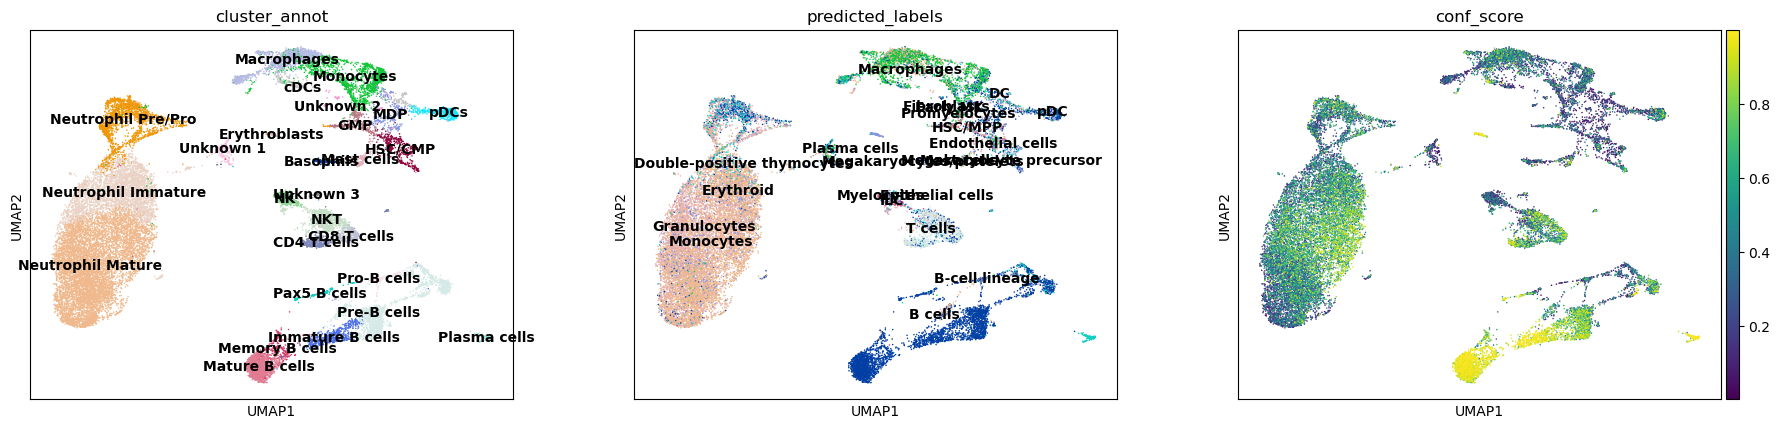

In [88]:
sc.pl.umap(adata, color = ['cluster_annot', 'predicted_labels', 'conf_score'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

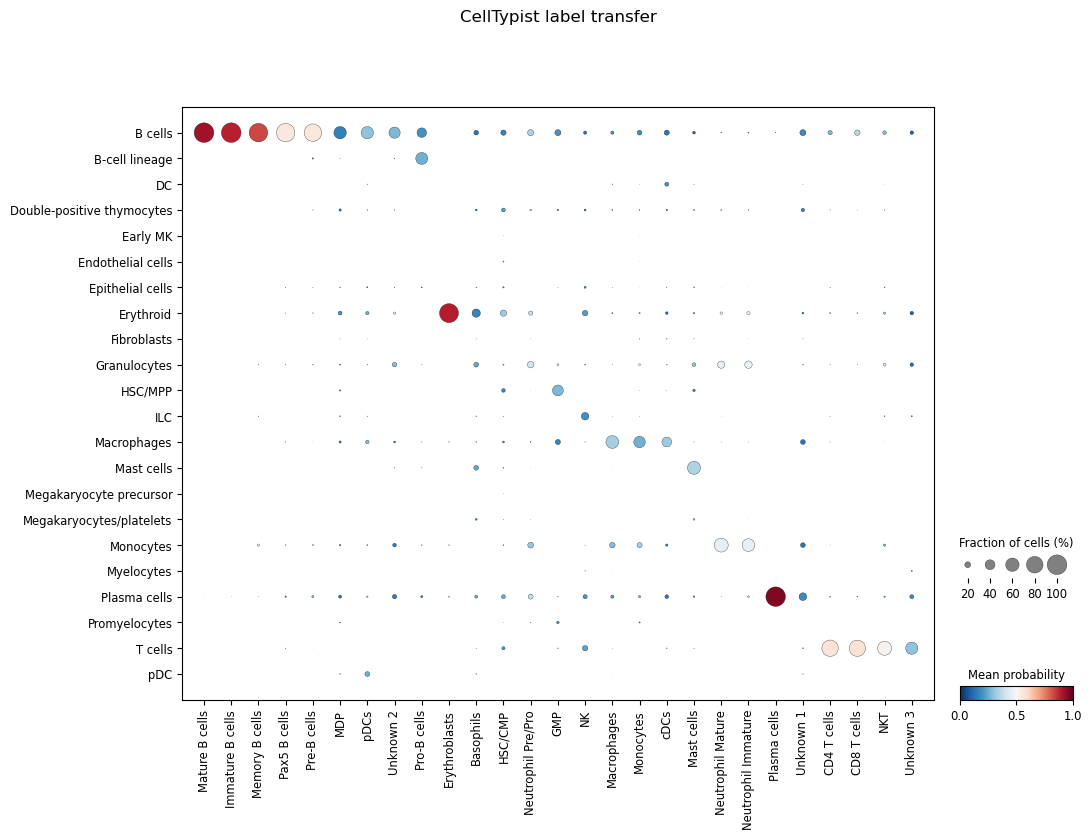

In [90]:
celltypist.dotplot(predictions, use_as_reference = 'cluster_annot', use_as_prediction = 'predicted_labels')

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [97]:
# Now load manual annotation data as reference

ref_adata = sc.read('../SingleR/manual_annot.h5ad')

In [100]:
ref_adata.var.features

Xkr4                Xkr4
Gm1992            Gm1992
Gm19938          Gm19938
Gm37381          Gm37381
Rp1                  Rp1
                 ...    
AC124606.1    AC124606.1
AC133095.2    AC133095.2
AC133095.1    AC133095.1
AC234645.1    AC234645.1
AC149090.1    AC149090.1
Name: features, Length: 32285, dtype: object

In [ ]:
# Set raw genes as index (but no need to capitalise)
#ref_adata.var.set_index(ref_adata.raw.var["features"], inplace=True)

Download another scRNA-seq dataset of 400 immune cells as a query.

In [101]:
query_adata = sc.read('../SingleR/results/mATLAS_facs.h5ad')

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) function.

In [102]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(ref_adata, labels = 'cluster_annot', n_jobs = 4, feature_selection = True)

🍳 Preparing data before training
✂️ 10776 non-expressed genes are filtered out
🔬 Input data has 24807 cells and 21509 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 4091 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [ ]:
# Save the model.
new_model.write('data/celltypist_model.pkl')

You can load this model by `models.Model.load`.

In [ ]:
new_model = models.Model.load('data/celltypist_model.pkl')

Next, we use this model to predict the query dataset of 400 immune cells.

In [ ]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(query_adata, model = 'data/celltypist_model.pkl', majority_voting = True)

🔬 Input data has 400 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 2607 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [ ]:
adata = predictions.to_adata()

In [ ]:
sc.tl.umap(adata)

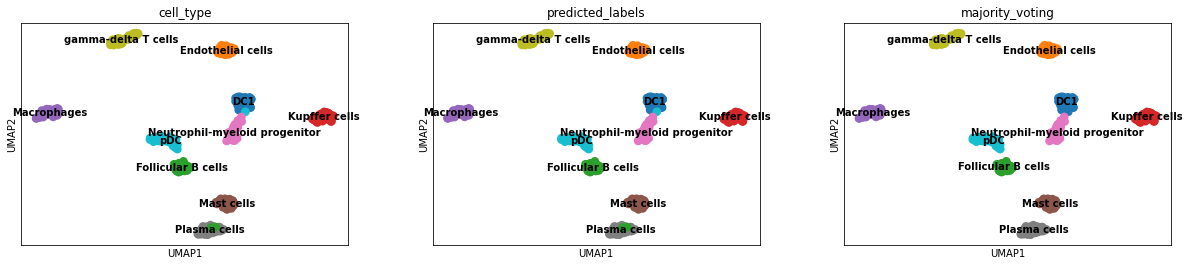

In [ ]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

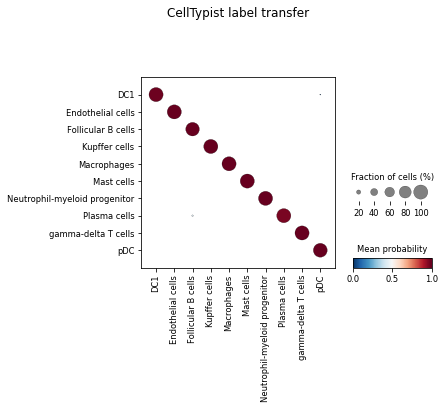

In [ ]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [ ]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [ ]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the top three driving genes of `Mast cells` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [ ]:
top_3_genes = model.extract_top_markers("Mast cells", 3)
top_3_genes

array(['TPSB2', 'TPSAB1', 'CPA3'], dtype=object)

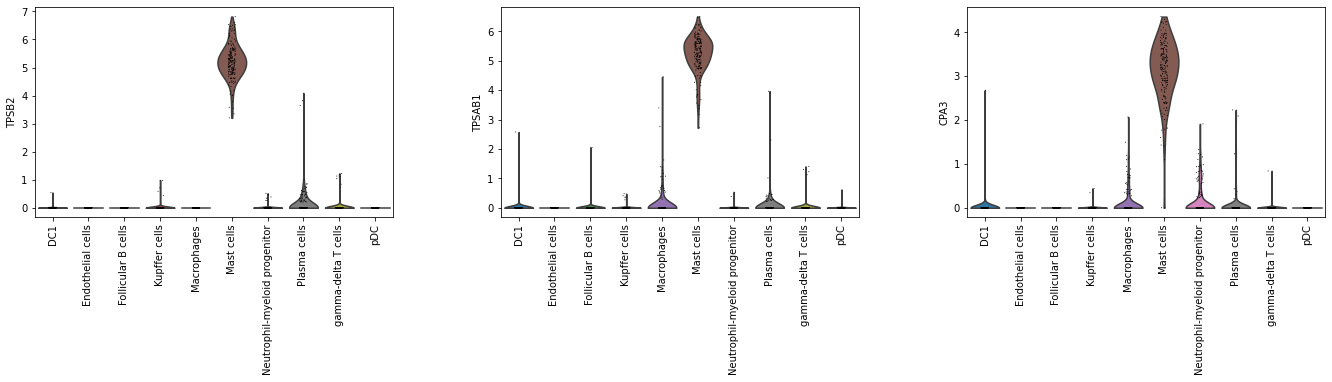

In [ ]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

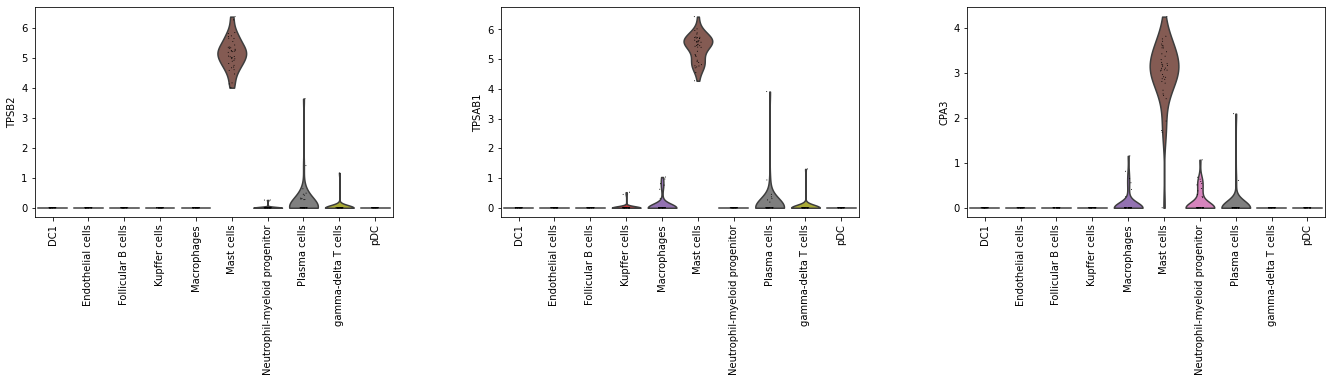

In [ ]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)